# Deep Q-Network

In [2]:
#Imports
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
import random

#Create Gym
from gym import wrappers
envCartPole = gym.make('CartPole-v1')
# envCartPole.seed(50) #Set the seed to keep the environment consistent across runs

In [3]:
#Global Variables
EPISODES = 500
TRAIN_END = 0

#Hyper Parameters
def discount_rate(): #Gamma
    return 0.95

def learning_rate(): #Alpha
    return 0.001

def batch_size(): #Size of the batch used in the experience replay
    return 24

nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
batch_size = batch_size()

In [7]:
class DeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []

    def build_model(self):
        model = keras.Sequential()
        model.add(keras.layers.Dense(24, input_dim=self.nS, activation='relu'))
        model.add(keras.layers.Dense(24, activation='relu'))
        model.add(keras.layers.Dense(self.nA, activation='linear'))
        model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(lr=self.alpha)) #Optimaizer: Adam (Feel free to check other options)
        return model

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA) #Explore
        action_vals = self.model.predict(state) #Exploit
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) #States
        nst = np.zeros( (0,self.nS) )#Next States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st)
        nst_predict = self.model.predict(nst)
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: 
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * np.amax(nst_action_predict_model)
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1 #Epochs is the number or iterations
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [7]:
dqn = DeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.001, 0.995 )

#Training
rewards = [] 
epsilons = []
TEST_Episodes = 0
for e in range(EPISODES):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0
    for time in range(200): 
        action = dqn.action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn.store(state, action, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        #done: CartPole fell.
        #time == 199: CartPole stayed upright
        if done or time == 199:
            rewards.append(tot_rewards)
            epsilons.append(dqn.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn.epsilon))
            break
        #Experience Replay
        if len(dqn.memory) > batch_size:
            dqn.experience_replay(batch_size)
    #If our current NN passes we are done
    #I am going to use the last 5 runs
    # if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
    #     #Set the rest of the EPISODES for testing
    #     TEST_Episodes = EPISODES - e
    #     TRAIN_END = e
    #     break

In [8]:
# #Test the agent that was trained
# #   In this section we ALWAYS use exploit don't train any more
# for e_test in range(TEST_Episodes):
#     state = envCartPole.reset()
#     state = np.reshape(state, [1, nS])
#     tot_rewards = 0
#     for t_test in range(210):
#         action = dqn.test_action(state)
#         nstate, reward, done, _ = envCartPole.step(action)
#         nstate = np.reshape( nstate, [1, nS])
#         tot_rewards += reward
#         #DON'T STORE ANYTHING DURING TESTING
#         state = nstate
#         #done: CartPole fell.
#         #t_test == 209: CartPole stayed upright
#         if done or t_test == 209:
#             rewards.append(tot_rewards)
#             epsilons.append(0) #We are doing full exploit
#             print("episode: {}/{}, score: {}, e: {}"
#                   .format(e_test, TEST_Episodes, tot_rewards, 0))
#             break;

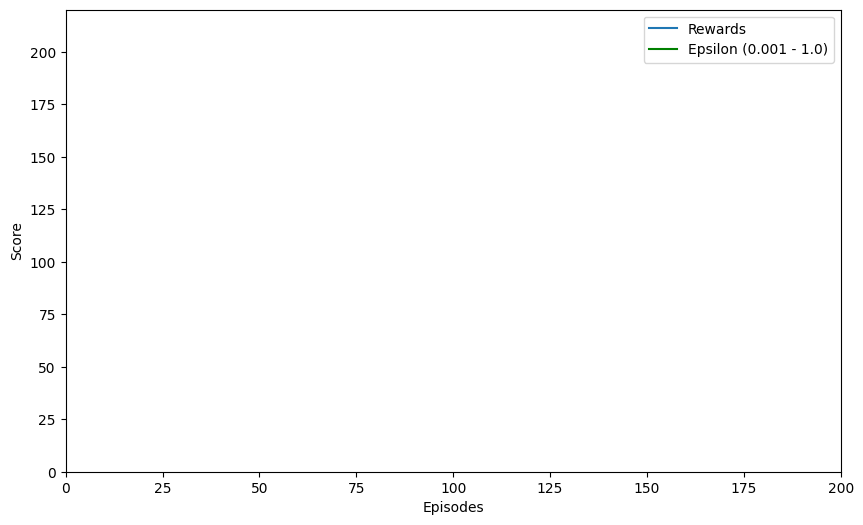

In [6]:
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.figure(figsize=(10, 6))
plt.plot(rewards, label='Rewards')
plt.plot(rolling_average, color='black', label='Average Scores')
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-', label='Epsilon (0.001 - 1.0)')
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.xlim((0, EPISODES))
plt.ylim((0, 220))
plt.legend()
plt.show()

envCartPole.close()